In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
df = pd.read_csv('https://raw.githubusercontent.com/ValeriyaTikhonovskaya/dz/main/final_dataset.csv')
df = df.drop('Unnamed: 0', axis = 1)

Изначально данная исследовательская работа выглядело как что-то веселое и не затейливое. Мы просто выделели интересные признаки, которые можно нарыть на Хэд хантере и хорошо спарсить. Как же мы ошибались... Из-за огромного количества костылей в коде сайта спаршенный датасет получился неимоверно сырым, и сейчас мы это будем потихоньку фиксить.

1. Избавимся от колонки ВУЗ. До того как начать парсить данные, этот признак выглядел достаточно важныы и интересным для анализа, однако уже после выяснилось, что, во-первых, ВУЗов слишком много, чтобы включить их в список категориальных переменных. Во-вторых, данная графа на хэд хантере заполняется пользователями вручную, что несет за собой полнейший хаос на болльшой выборке. Удаляем!


In [18]:
df = df.drop('вуз', axis = 1)

2. Теперь нужно позаботиться о непрерывных признаках, которые спарсились как обычные нечисловые объекты

    2.1. Начнем с исправления колонок возраст и опыт, потому что они имеют одинаковое оформление. Взяв срез до 2 символа (включительно) мы получим количество лет возможно с пробелом.

In [19]:
df[['возраст', 'опыт работы']]= df[['возраст', 'опыт работы']].applymap(lambda x: float(str(x)[:2].strip()), na_action= 'ignore')

/var/folders/6p/80ct6mvj5cv9c6fyfy3vdvfc0000gn/T/ipykernel_11049/2278824240.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[['возраст', 'опыт работы']]= df[['возраст', 'опыт работы']].applymap(lambda x: float(str(x)[:2].strip()), na_action= 'ignore')


    2.2. Теперь поправим ЗП. Для этого мало того, что нужно избавиться от дурацкой надписи "на руки" (на разных языках), дак еще и привести все к одной валюте (слава богу, на hh есть только доллары, рубли и евро). Возьмем по нынешнем меркам: 91.63 ₽ за один доллар и 98.73 ₽ за одно евро. Для этого напишем универсальную функцию

In [20]:
def blagodat(x):
  if '€' in x:
    return int(x[:-9].replace('\u2009', ''))*98.73
  elif '₽' in x:
    return int(x[:-9].replace('\u2009', ''))
  else:
    return int(x[:-9].replace('\u2009', ''))*91.63

In [21]:
df['желаемая з/п'] = df['желаемая з/п'].map(blagodat)

3. Подходит время и до категориальных признаков. Напомню, некоторые наблюдения на английском просто потому что

    3.1 Начнем с мужчин и женщин, тут будет все совсем просто

In [22]:
df['пол'] = df['пол'].replace({'Male': 'Мужчина', 'Female': 'Женщина'})
df = pd.get_dummies(df, columns = ['пол'], dtype = int, drop_first = True)
df = df.drop('пол_Пол не указан', axis = 1)

    3.2. Далее плавно переходим к образованию. Здесь все тоже достаточно просто, ведь высшее образование может быть или не быть, без разницы, что там айтишники понапридумывали в своих анкетах

In [23]:
df['образование'] = ((df['образование'] == 'Высшее образование') | (df['образование'] == 'Higher education'))
df['образование'] = df['образование'].map(int)

    3.3. Теперь поговорим про последнее место работы. Довольно интересная переменная, она хранит в себе довольно большой объем информации, однако нам по большей части важно лишь одно -- работает ли человек в данный момент на этой работе или нет, поэтому опять применим бинарную классификацию

In [24]:
df['Последнее место работы'] = df['Последнее место работы'].map(lambda x: ('время' in x) or ('currently' in x), na_action='ignore')
df['Последнее место работы'] = df['Последнее место работы'].map(int, na_action='ignore')

    3.4. Теперь нужно что-то решать с занятостью. Но для начала все опять нужно перевести с тарабарского на православный. Для начало вообще посмотрим, из каких значений состоит столбец

In [25]:
df['занятость'].unique()

array(['Занятость: полная занятость',
       'Employment: full time, part time, project work',
       'Занятость: частичная занятость',
       'Занятость: полная занятость, частичная занятость',
       'Занятость: полная занятость, частичная занятость, проектная работа',
       'Employment: full time, part time, project work, work placement',
       'Занятость: полная занятость, частичная занятость, проектная работа, волонтерство, стажировка',
       'Занятость: частичная занятость, проектная работа',
       'Занятость: полная занятость, частичная занятость, стажировка',
       'Занятость: полная занятость, частичная занятость, проектная работа, стажировка',
       'Занятость: проектная работа',
       'Занятость: полная занятость, проектная работа',
       'Employment: full time, project work',
       'Занятость: частичная занятость, проектная работа, стажировка',
       'Employment: full time, part time, work placement',
       'Employment: full time', 'Занятость: полная занятость, с

In [26]:
eng_to_rus = {
    'Employment': 'Занятость', 
    'full': 'полная', 
    'time': 'занятость', 
    'part': 'частичная', 
    'project': 'проектная', 
    'volunteering': 'волонтерство',
    'placement': 'стажировка',
    'work': 'работа'
}

def pravoslavie(el):
    for key in eng_to_rus:
        if key in str(el):
            el = str(el).replace(key, eng_to_rus[key])
    el = el.lower()
    el = el.replace(':', '')
    el = el.replace('занятость', '')
    el = el.replace('работа', '')
    el = el.replace(' ', '')
    return el
    
def one_hot_encode(df, column):
    dummies = df[column].str.get_dummies(sep=',')
    return df.join(dummies)


In [27]:
df['занятость'] = df['занятость'].map(pravoslavie)
df = one_hot_encode(df, 'занятость')
df = df.drop('занятость', axis = 1)

    3.5. Предпоследняя часть -- языки. Так как парсили мы hh.ru, где пользователи сами заполняют данную графу, значения получились очень "интересными" и их обработка, займет довольно много времени. Поэтому сфокусируемся на английском языке. Будем считать, что человек обладает минимальными необходимыми навыками в случае, если его уровень владения языком хотя бы B2

In [28]:
def logic_lang(el):
    if ('Английский — B2' or 'Английский — C1' or 'Английский — C2' or 'English — C2' or 'English — B2' or 'English — C1') in str(el):
        el = 1
    else:
        el = 0
    return el

In [29]:
df['язык'] = df['язык'].map(logic_lang)

    3.6. Надо бы города тоже перевести

In [ ]:
sorted(df['регион'].unique())

In [30]:
a = sorted(df['регион'].unique())
eng_city = a[:15]
rus_city = [
    'Донецк',
    'Краснодар',
    'Красноярск',
    'Москва',
    'Находка',
    'Нальчик',
    'Новосибирск',
    'Омск',
    'Ростов-на-Дону',
    'Рязань',
    'Санкт-Петербург',
    'Самара',
    'Таганрог',
    'Томск',
    'Владикавказ'
]
rus_eng_city_dict = {eng_city[i]: rus_city[i] for i in range(len(eng_city))}
df['регион'] = df['регион'].replace(rus_eng_city_dict)

Здесь вроде как все очевидно: применяем OHE-кодирование, но вот беда, иметь дело с 201 переменными(см. ниже) не очень хочется. Поэтому прикинем, каких городов в нашей выборке сколько.

In [35]:
print('Количество различных регионов:', len(df['регион'].unique()))

Количество различных регионов: 201


In [41]:
md = {city: df['регион'][df['регион'] == city].shape[0] for city in df['регион'].unique()}
sorted(md.items(), key = lambda x: x[1])[::-1][:4]

[('Москва', 239),
 ('Санкт-Петербург', 93),
 ('Краснодар', 27),
 ('Новосибирск', 25)]

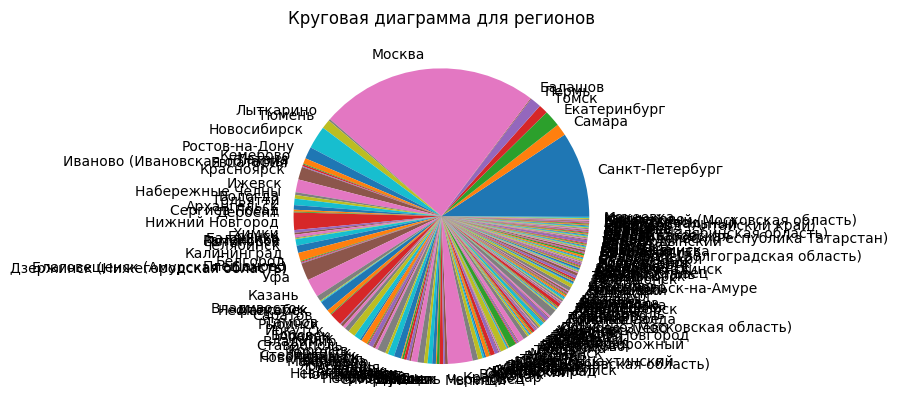

In [42]:
plt.pie(md.values(), labels = list(md.keys()))
plt.title('Круговая диаграмма для регионов')
plt.show()

Ну и жуть конечно у нас получилась. Надо что-то делать...

Как можно заметить в отсортированном по значениям словаре ('md') и на этой "прекрасной" круговой диаграмме, наибольшие категории -- это мск(199) и спб(82), а остальных ну сильно меньше. Раз так, давайте выделим три категории: Мск, СпБ и другое, а потом уже и OHE не грех применить будет.

In [44]:
def russia_be_like(gorod):
    if gorod != 'Москва' and gorod != 'Санкт-Петербург':
        gorod = 'Другое'
    return gorod

Text(0.5, 1.0, 'Круговая диаграмма для регионов')

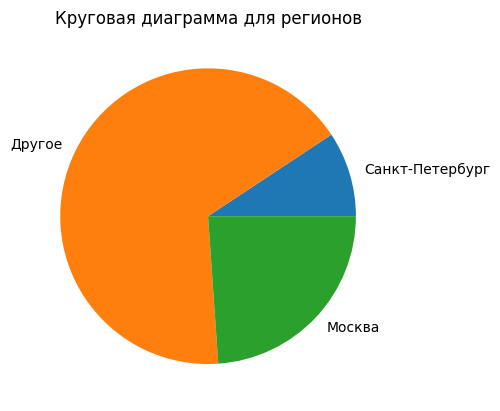

In [45]:
df['регион'] = df['регион'].map(russia_be_like)
md1 = {city: df['регион'][df['регион'] == city].shape[0] for city in df['регион'].unique()}
df = pd.get_dummies(df, columns = ['регион'], dtype = int, drop_first = True)
plt.pie(md1.values(), labels = md1.keys())
plt.title('Круговая диаграмма для регионов')

Так как здесь мы не втупую почистили данные, а вроде даже как-то пощупали данные, давайте дадим небольшой вывод, к полученным результатам:

* Москва -- топ-1 город, где люди ищут работу, что неудивительно, ведь Москва не Россия и как рабочих мест там больше, так и в среднем з/п там выше
* Петербург здесь стоит на 2 месте, по количеству желающих, опять же по тем же причинам.
* При этом радует, что Россия большая и бОльшая часть людей хотят остаться в регионах (суммарно естественно)